In [4]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("..\Python_Checkpoints\Africa_climate_change.csv")

In [3]:
data.head()

,DATE,PRCP,TAVG,TMAX,TMIN,COUNTRY
0,19800101 000000,NaN,54.0,61.0,43.0,Tunisia
1,19800101 000000,NaN,49.0,55.0,41.0,Tunisia
2,19800101 000000,0.0,72.0,86.0,59.0,Cameroon
3,19800101 000000,NaN,50.0,55.0,43.0,Tunisia
4,19800101 000000,NaN,75.0,91.0,NaN,Cameroon


In [4]:
data.shape


(464815, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464815 entries, 0 to 464814
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   DATE     464815 non-null  object 
 1   PRCP     177575 non-null  float64
 2   TAVG     458439 non-null  float64
 3   TMAX     363901 non-null  float64
 4   TMIN     332757 non-null  float64
 5   COUNTRY  464815 non-null  object 
dtypes: float64(4), object(2)
memory usage: 21.3+ MB


In [6]:
data.columns = data.columns.str.strip().str.lower()
data.columns

Index(['date', 'prcp', 'tavg', 'tmax', 'tmin', 'country'], dtype='object')

In [7]:
data.isnull().sum()

date            0
prcp       287240
tavg         6376
tmax       100914
tmin       132058
country         0
dtype: int64

In [8]:
data['date'] = data['date'].astype(str).str.slice(0, 8)

# Convert to datetime
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month



In [9]:
data.head()

,date,prcp,tavg,tmax,tmin,country,year,month
0,1980-01-01,NaN,54.0,61.0,43.0,Tunisia,1980,1
1,1980-01-01,NaN,49.0,55.0,41.0,Tunisia,1980,1
2,1980-01-01,0.0,72.0,86.0,59.0,Cameroon,1980,1
3,1980-01-01,NaN,50.0,55.0,43.0,Tunisia,1980,1
4,1980-01-01,NaN,75.0,91.0,NaN,Cameroon,1980,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464815 entries, 0 to 464814
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     464815 non-null  datetime64[ns]
 1   prcp     177575 non-null  float64       
 2   tavg     458439 non-null  float64       
 3   tmax     363901 non-null  float64       
 4   tmin     332757 non-null  float64       
 5   country  464815 non-null  object        
 6   year     464815 non-null  int32         
 7   month    464815 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2), object(1)
memory usage: 24.8+ MB


In [11]:
print(data['date'].dtype)

datetime64[ns]


In [12]:
mask =  data['tavg'].isna() & data['tmin'].notna() & data['tmax'].notna()
data.loc[mask, 'tavg'] = (data.loc[mask, 'tmin'] + data.loc[mask, 'tmax']) / 2



In [13]:
data.loc[mask, 'tavg'].head(5)

24     78.0
26     78.0
64     77.5
85     78.5
105    80.0
Name: tavg, dtype: float64

In [14]:
imputed_chunks = []
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=2)

for country in data['country'].unique():
    chunk = data[data['country'] == country].copy()
    
    # Build feature matrix for this chunk
    chunk_encoded = pd.get_dummies(chunk['country'], prefix='country')
    chunk_ready = pd.concat([chunk[['tavg','tmin','tmax','prcp','year','month']], chunk_encoded], axis=1)
    
    # Scale + Impute
    scaled = scaler.fit_transform(chunk_ready)
    imputed = imputer.fit_transform(scaled)
    chunk[chunk_ready.columns] = scaler.inverse_transform(imputed)
    
    imputed_chunks.append(chunk)

# Combine all chunks
data_imputed = pd.concat(imputed_chunks, axis=0)


In [ ]:
output_file = "Africa_climate_change_clean.csv"
data_imputed.to_csv(output_file,index= True)


In [19]:
data_imputed = pd.read_csv("..\Python_Checkpoints\Africa_climate_change_clean.csv")

In [ ]:
data_imputed.drop(columns=['country_Tunisia', 'country_Cameroon', 'country_Senegal', 'country_Egypt', 'country_Angola'], inplace=True)
data_imputed.isnull().sum()

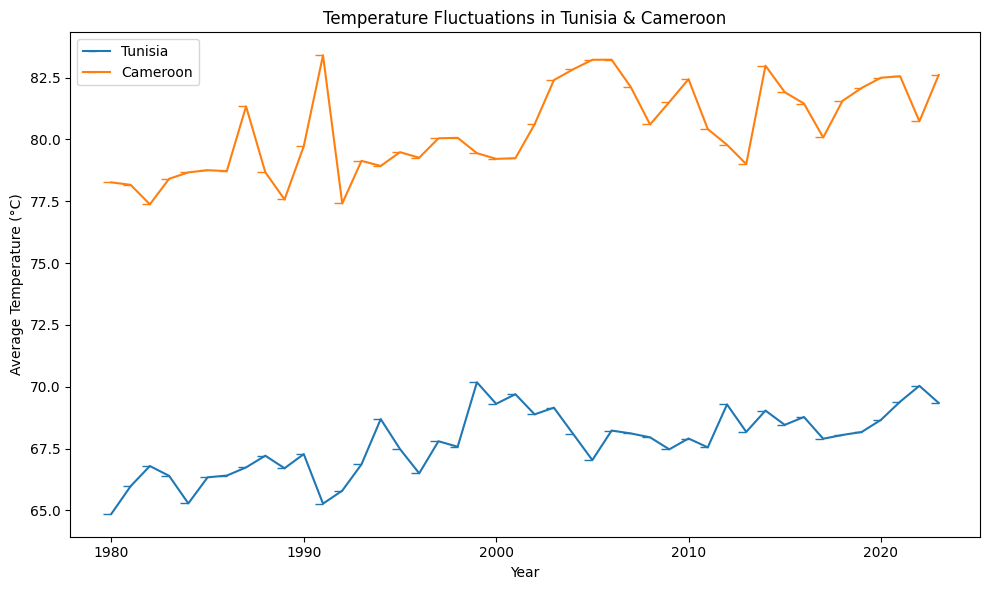

In [20]:
#Line Chart – Temperature Fluctuations in Tunisia & Cameroon

data_tc = data_imputed[data_imputed['country'].isin(['Tunisia','Cameroon'])].copy()
avg_temp = data_tc.groupby(['year','country'])['tavg'].mean().reset_index()


fig, ax = plt.subplots(figsize=(10, 6))
for country in ['Tunisia','Cameroon']:
    country_data = avg_temp[avg_temp['country'] == country]
    country_data.head()
    ax.plot(country_data['year'],
            country_data['tavg'],
            label=country,
            marker=0)

ax.set_title('Temperature Fluctuations in Tunisia & Cameroon')
ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature (°C)')
ax.legend()
plt.tight_layout()
plt.show()


- Tunisia’s climate appears to be warming over time, possibly due to desertification, urbanization, or broader global climate change.

- Cameroon’s temperatures are naturally higher, but the long-term trend is less pronounced. It may be experiencing seasonal volatility more than directional change.


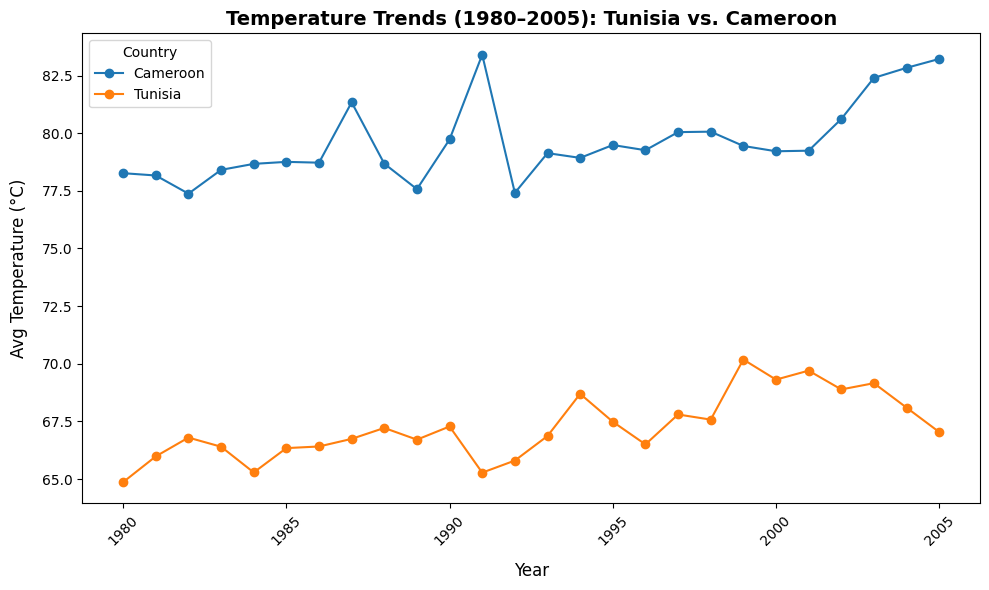

In [16]:
filtered_data = avg_temp[(avg_temp['year'] >= 1980) & (avg_temp['year'] <= 2005)]
fig, ax = plt.subplots(figsize=(10, 6))

for country in filtered_data['country'].unique():
    country_data = filtered_data[filtered_data['country'] == country]
    ax.plot(
        country_data['year'], 
        country_data['tavg'], 
        label=country,
        marker='o'
    )


ax.set_title('Temperature Trends (1980–2005): Tunisia vs. Cameroon', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, labelpad=10)
ax.set_ylabel('Avg Temperature (°C)', fontsize=12, labelpad=10)


ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xticks([1980, 1990, 2000])
# ax.set_xticklabels(['📅 1980', '📅 1990', '📅 2000'], fontsize=10, rotation=45)

ax.legend(title='Country', fontsize=10)

plt.tight_layout()
plt.show()

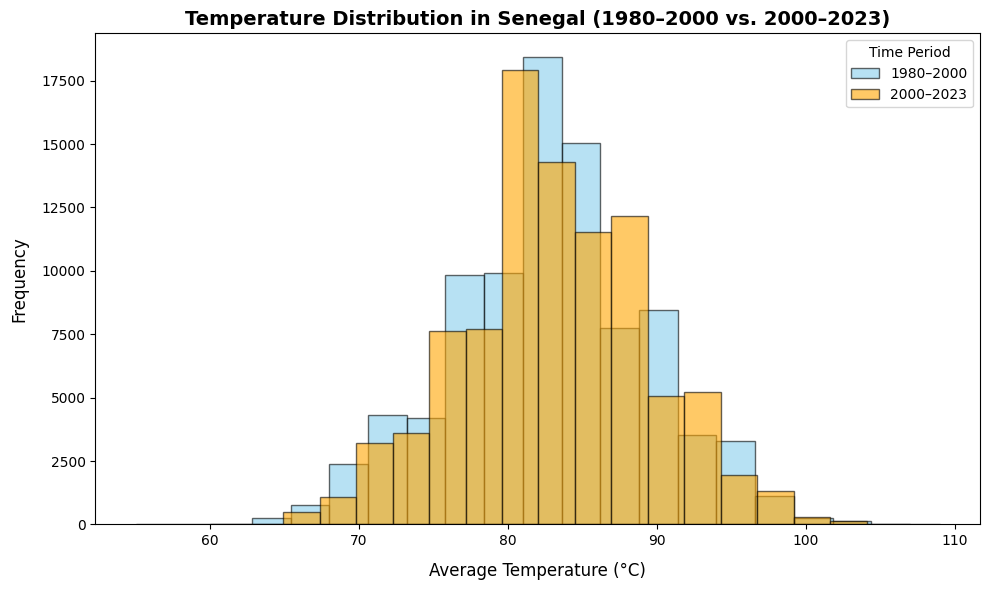

In [27]:
#Create Histograms to show temperature distribution in Senegal between [1980,2000] and [2000,2023] (in the same figure). 

senegal_early = data_imputed[(data_imputed['country'] == 'Senegal') & (data_imputed['year'] >= 1980) & (data_imputed['year'] <= 2000)]
senegal_recent = data_imputed[(data_imputed['country'] == 'Senegal') & (data_imputed['year'] > 2000) & (data_imputed['year'] <= 2023)]

temps_early = senegal_early['tavg']
temps_recent = senegal_recent['tavg']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(temps_early, bins=20, alpha=0.6, label='1980–2000', color='skyblue', edgecolor='black')
ax.hist(temps_recent, bins=20, alpha=0.6, label='2000–2023', color='orange', edgecolor='black')


ax.set_title('Temperature Distribution in Senegal (1980–2000 vs. 2000–2023)', fontsize=14, fontweight='bold')
ax.set_xlabel('Average Temperature (°C)', fontsize=12, labelpad=10)
ax.set_ylabel('Frequency', fontsize=12, labelpad=10)
ax.legend(title='Time Period')

plt.tight_layout()
plt.show()


# Temperature Distribution in Senegal (1980–2000 vs. 2000–2023)

## Overview

This histogram compares the distribution of average temperatures in Senegal across two distinct time periods:

- **1980–2000** (blue bars)
- **2000–2023** (orange bars)

The x-axis represents average temperature in degrees Celsius (°C), while the y-axis shows the frequency of temperature occurrences.

## Key Observations

- **Shift to the right**: The orange bars are generally positioned further right than the blue ones, indicating that higher temperatures have become more common in the recent period.
- **Taller orange bars**: The frequency of warmer temperatures has increased, suggesting a denser concentration of higher temperature values.
- **Flattening of blue bars**: The earlier period shows a more spread-out distribution, implying greater variability or cooler extremes.

## Interpretation

This histogram provides visual evidence of climate warming in Senegal:

- The **modal temperature** (most frequent value) has increased.
- The **distribution has shifted** toward hotter values.
- The **frequency of high temperatures** has intensified.

These changes suggest a long-term warming trend, consistent with broader climate change patterns. The histogram effectively highlights how temperature behavior has evolved over time, offering a clear comparison between historical and recent climate conditions.


In [ ]:
#Select the best chart to show the Average temperature per country.
avg_temp_by_country = data_imputed.groupby('country')['tavg'].mean().sort_values().reset_index()


fig = px.bar(
    avg_temp_by_country,
    x='country',
    y='tavg',
    orientation='v',
    title='Average Temperature per Country',
    labels={'tavg': 'Avg Temperature (°C)', 'country': 'Country'},
    color='tavg',
    color_continuous_scale='YlOrRd'  # Optional: adds a heatmap feel
)

fig.update_layout(
    xaxis_title='Average Temperature (°C)',
    yaxis_title='Country',
    title_font_size=18,
    xaxis_tickformat='.1f',
    margin=dict(l=100, r=40, t=60, b=40)
)


fig.show()



In [ ]:
#  How does average temperature vary by month across countries?
monthly_avg = data_imputed.groupby(['country', 'month'])['tavg'].mean().reset_index()

fig = px.line(monthly_avg, x='month', y='tavg', color='country',
              title='Monthly Temperature Patterns by Country',
              labels={'month': 'Month', 'tavg': 'Avg Temp (°C)'})
fig.show()

